## **EDA and prediction on Stroke data**
In this notebook, i make EDA and data processing(including outliers process, scalling,oversampling for data bias and  feature selection),also trained logistic regression model and interpret the logistic model with SHAP.

Analysis the shap summary beeswarm plot, the most important fearute 'age' and its effect direction on prediction be more understandable. The shap is more interpretable and intuitive. 

### Import libraries and dataset

In [46]:
!pip install shap h2o

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [47]:
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from sklearn import metrics
import seaborn as sns
import plotly.express as px
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil

In [48]:
#Reading the HeartAttack data
df=pd.read_csv("full_data.csv")
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   object 
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   object 
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   object 
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   object 
 10  stroke             4981 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 428.2+ KB


In [50]:
df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [51]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000
mean,43.419859,0.096165,0.055210,105.943562,28.498173,0.049789
std,22.662755,0.294848,0.228412,45.075373,6.790464,0.217531
min,0.080000,0.000000,0.000000,55.120000,14.000000,0.000000
25%,25.000000,0.000000,0.000000,77.230000,23.700000,0.000000
50%,45.000000,0.000000,0.000000,91.850000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,113.860000,32.600000,0.000000
max,82.000000,1.000000,1.000000,271.740000,48.900000,1.000000


### EDA

#### Stroke numbers in dataset

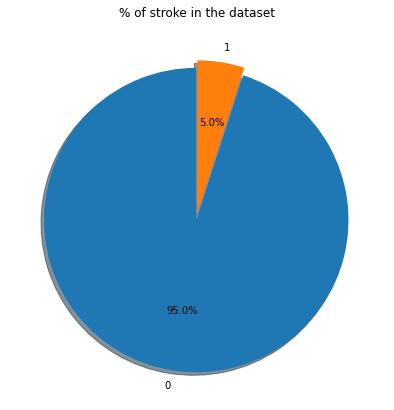

In [52]:
labels =df['stroke'].value_counts(sort = True).index
sizes = df['stroke'].value_counts(sort = True)
explode = (0.05,0) 
plt.figure(figsize=(7,7))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90,)
plt.title('% of stroke in the dataset')
plt.show()


#### Distribution of continuous variables

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


Text(0.5, 0, 'average glucose level in blood')

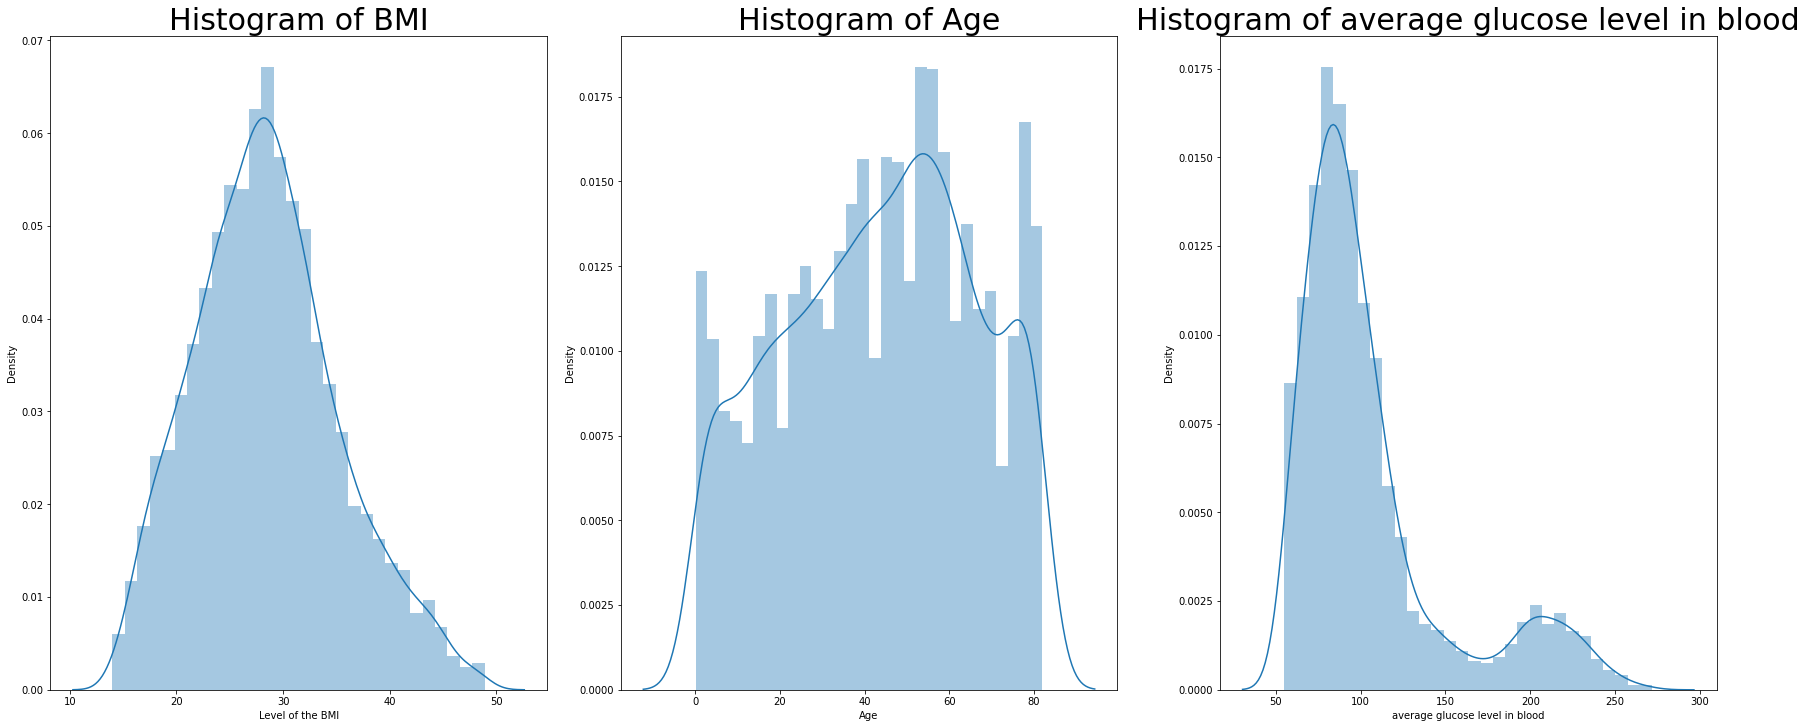

In [53]:
fig, axes = plt.subplots(1,3,figsize=(25,10),constrained_layout=True)
sns.distplot(df.bmi, bins=30,ax=axes[0])
axes[0].set_title(f'Histogram of BMI',fontsize=30)
axes[0].set_xlabel("Level of the BMI")
sns.distplot(df.age, bins=30,ax=axes[1])
axes[1].set_title(f'Histogram of Age',fontsize=30)
axes[1].set_xlabel("Age")
sns.distplot(df.avg_glucose_level, bins=30,ax=axes[2])
axes[2].set_title(f'Histogram of average glucose level in blood',fontsize=30)
axes[2].set_xlabel("average glucose level in blood")

#### Categorical variables

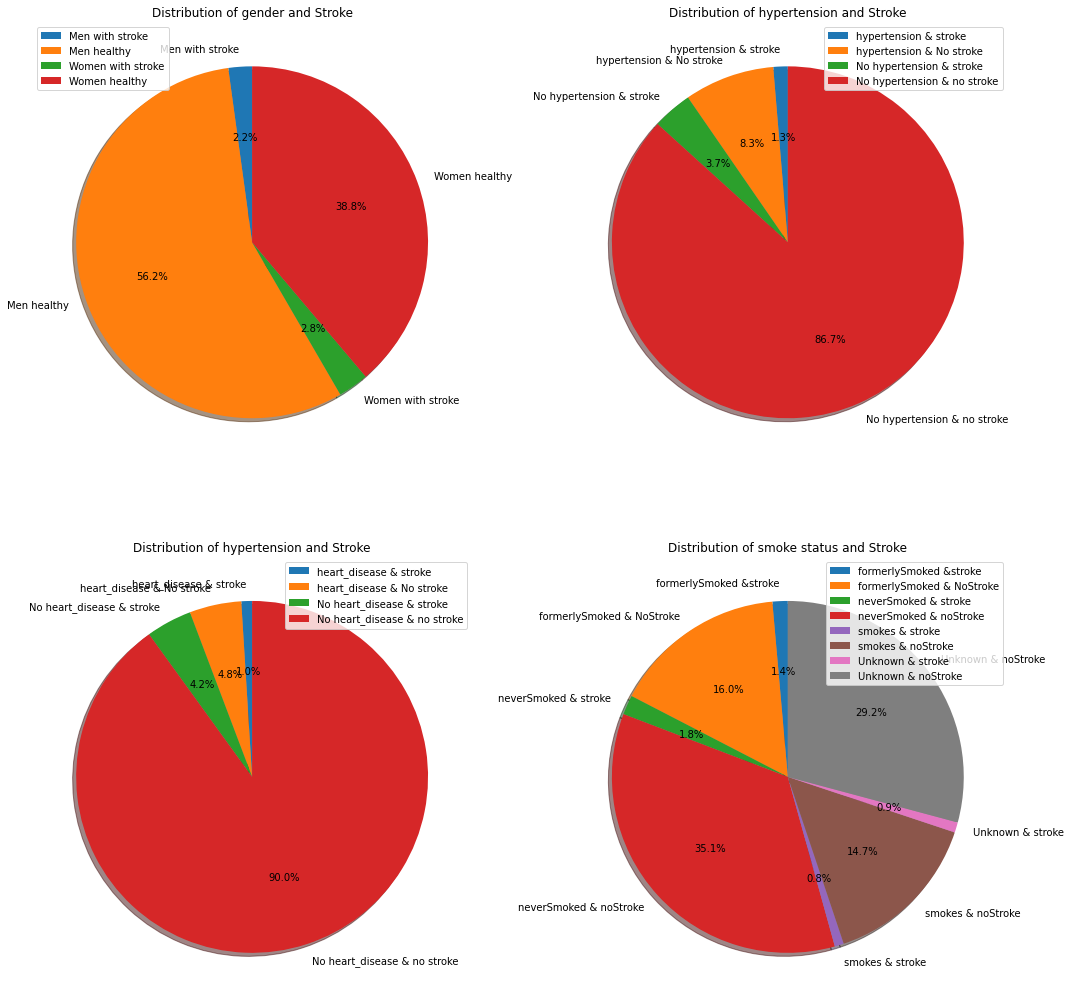

In [54]:
#gender & stroke
len_data = len(df)
len_w = len(df[df["gender"]=="Male"])
len_m = len_data - len_w
men_stroke = len(df.loc[(df["stroke"]==1)&(df['gender']=="Male")])
men_no_stroke = len_m - men_stroke
women_stroke = len(df.loc[(df["stroke"]==1) & (df['gender']=="Female")])
women_no_stroke = len_w - women_stroke
labels = ['Men with stroke','Men healthy','Women with stroke','Women healthy']
values = [men_stroke, men_no_stroke, women_stroke, women_no_stroke]
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.title("Distribution of gender and Stroke")
plt.pie(values,labels=labels,autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.legend()
#hypertension & stroke
len_h = len(df[df["hypertension"]==1])
len_nh = len_data - len_h
hy_stroke = len(df.loc[(df["stroke"]==1)&(df['hypertension']==1)])
hy_no_stroke = len_h - hy_stroke
nhy_stroke = len(df.loc[(df["stroke"]==1) & (df['hypertension']==0)])
nhy_no_stroke = len_nh - nhy_stroke
labels1 = ['hypertension & stroke','hypertension & No stroke','No hypertension & stroke','No hypertension & no stroke']
values1 = [hy_stroke, hy_no_stroke, nhy_stroke, nhy_no_stroke]
plt.subplot(2,2,2)
plt.title("Distribution of hypertension and Stroke")
plt.pie(values1,labels=labels1, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.legend()
#heart_disease & stroke
len_hd = len(df[df["heart_disease"]==1])
len_nhd = len_data - len_h
hd_stroke = len(df.loc[(df["stroke"]==1)&(df['heart_disease']==1)])
hd_no_stroke = len_hd - hd_stroke
nhd_stroke = len(df.loc[(df["stroke"]==1) & (df['heart_disease']==0)])
nhd_no_stroke = len_nhd - nhd_stroke
labels2 = ['heart_disease & stroke','heart_disease & No stroke','No heart_disease & stroke','No heart_disease & no stroke']
values2 = [hd_stroke, hd_no_stroke, nhd_stroke, nhd_no_stroke]
plt.subplot(2,2,3)
plt.title("Distribution of hypertension and Stroke")
plt.pie(values2,labels=labels2, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.legend()
#smoking_status & stroke
len_fs = len(df[df["smoking_status"]=="formerly smoked"])
len_ns = len(df[df["smoking_status"]=="never smoked"])
len_smokes = len(df[df["smoking_status"]=="smokes"])
len_unknow=len_data - len_fs-len_ns-len_smokes
fs_stroke = len(df.loc[(df["stroke"]==1)&(df['smoking_status']=="formerly smoked")])
fs_no_stroke = len_fs - fs_stroke
ns_stroke = len(df.loc[(df["stroke"]==1) & (df['smoking_status']=="never smoked")])
ns_no_stroke = len_ns - ns_stroke
smokes_stroke = len(df.loc[(df["stroke"]==1) & (df['smoking_status']=="smokes")])
smokes_no_stroke = len_smokes - smokes_stroke
unknow_stroke = len(df.loc[(df["stroke"]==1) & (df['smoking_status']=="Unknown")])
unknow_no_stroke = len_unknow - unknow_stroke
labels3 = ['formerlySmoked &stroke','formerlySmoked & NoStroke','neverSmoked & stroke','neverSmoked & noStroke','smokes & stroke','smokes & noStroke','Unknown & stroke','Unknown & noStroke']
values3 = [fs_stroke, fs_no_stroke, ns_stroke, ns_no_stroke,smokes_stroke,smokes_no_stroke,unknow_stroke,unknow_no_stroke]
plt.subplot(2,2,4)
plt.title("Distribution of smoke status and Stroke")
plt.pie(values3,labels=labels3, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.legend()
plt.tight_layout()
plt.show()

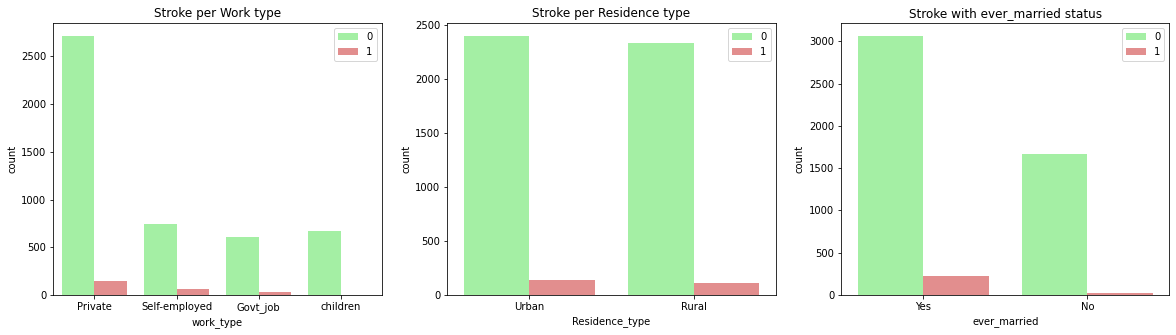

In [55]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
#Stroke/Work_type
sns.countplot(x='work_type', hue='stroke', data=df,palette=["palegreen","lightcoral"])
plt.title("Stroke per Work type")
plt.legend()
plt.subplot(1,3,2)
#Stroke/Residence_type
sns.countplot(x='Residence_type', hue='stroke', data=df,palette=["palegreen","lightcoral"])
plt.title("Stroke per Residence type")
plt.legend()
plt.subplot(1,3,3)
#Stroke/ever_married
sns.countplot(x='ever_married', hue='stroke', data=df,palette=["palegreen","lightcoral"])
plt.title("Stroke with ever_married status")
plt.legend()
plt.show()

### Checking variavbles ranges and outliers

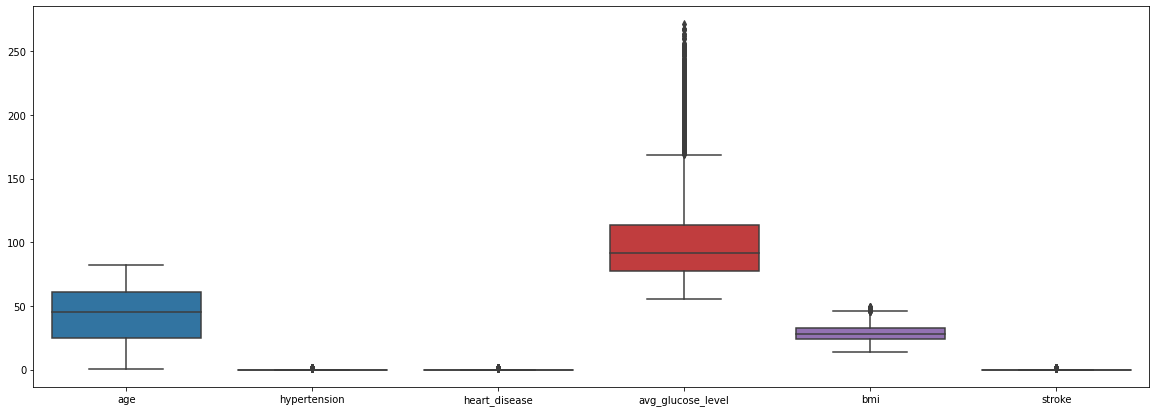

In [56]:
#Checking the Ranges of the predictor variables and dependent variable
plt.figure(figsize=(20,7))
sns.boxplot(data=df)

### Data processing & Feature selection
#### Removing outliers

In [57]:
cat_cols = ['gender','hypertension','heart_disease','ever_married','work_type','Residence_type','smoking_status']
cont_cols=['age','avg_glucose_level','bmi']

def treat_outlier(x):
    sorted(x)
    q1,q3=np.percentile(x,[25,75])
    iqr=q3-q1
    l_r=q1-(1.5*iqr)
    u_r=q3+(1.5*iqr)
    return l_r,u_r  

for i in df[cont_cols].columns:
    lr,ur = treat_outlier(df[i])
    df[i] = np.where(df[i]>ur,ur,df[i])
    df[i] = np.where(df[i]<lr,lr,df[i])


#### Scaling & Data Imbalance processed with SMOTE

In [58]:

#convering categorical features to numerical
df['gender'] = df['gender'].map({'Male':int(1),'Female':int(0)})
df['ever_married'] = df['ever_married'].map({'Yes':int(1),'No':int(0)})
df = pd.get_dummies(df,columns=['work_type','smoking_status','Residence_type'],drop_first=True)
y=df["stroke"]
X = df.drop(columns=["stroke"])
print(sum(y==1))
print(sum(y==0))


248
4733


In [59]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
# scaling the continuous featuree
X[cont_cols] = scaler.fit_transform(X[cont_cols])


In [60]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X,y.ravel())

In [61]:
#split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)


#### Feature correlation

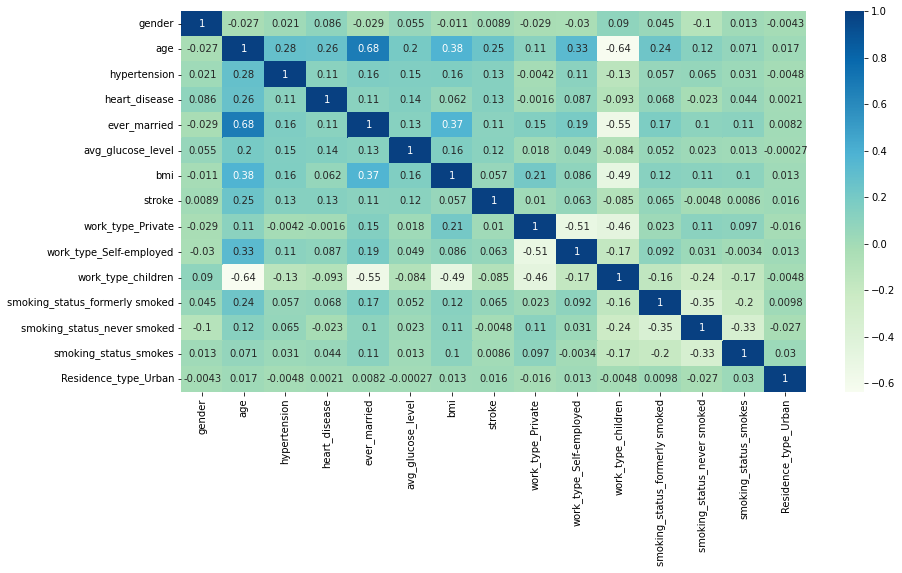

In [62]:
#the heat map of the correlation
correlation = df.corr()
plt.figure(figsize = (14,7))
sns.heatmap(correlation, annot = True, cmap = 'GnBu')

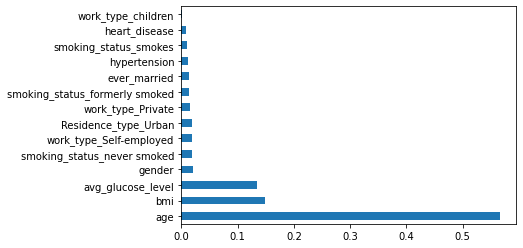

In [63]:
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
# define the model
model = RandomForestRegressor()
# Train the model using the training sets
model.fit(X_train,y_train)

# Make predictions using the training set
y_pred = model.predict(X_train)
# get importance
importance = model.feature_importances_
# summarize feature importance
feat_importances = pd.Series(importance, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

In [71]:
X_train_res=X_train.drop(columns=['work_type_children','heart_disease'])
X_test_res=X_test.drop(columns=['work_type_children','heart_disease'])

From the feature importance plot, we can find that work_type_children and hypertension is less important than other variables, so we try drop them from data and observe how model will be affected.

### Model training and basic interpret
#### Linear model: Logistic regression

In [72]:
#Create Logistic regression object
logit = LogisticRegression(random_state= 0)
# Train the model using the training sets with feature selection
logit.fit(X_train_res, y_train)
# Make predictions using the testing set
logit_pred = logit.predict(X_test_res)

print("The test accuracy score of Logistric Regression is ", metrics.accuracy_score(y_test, logit_pred))


The test accuracy score of Logistric Regression is  0.7808870116156283


In [73]:
#Create Logistic regression object
logit2 = LogisticRegression(random_state= 0)
# Train the model using the training sets without feature selection
logit2.fit(X_train, y_train)
# Make predictions using the testing set
logit_pred1 = logit2.predict(X_test)

print("The test accuracy score of Logistric Regression is ", metrics.accuracy_score(y_test, logit_pred1))


The test accuracy score of Logistric Regression is  0.7787750791974657


After feature selection, model is more interpretable and slightly increase performance.

In [74]:
coeff = pd.DataFrame(logit.coef_, columns=X_train_res.columns)
coeff.T

,0
gender,-0.393348
age,3.433382
hypertension,-0.330964
ever_married,-0.365964
avg_glucose_level,0.203538
bmi,0.195212
work_type_Private,-0.308209
work_type_Self-employed,-0.843669
smoking_status_formerly smoked,-0.478210
smoking_status_never smoked,-0.832044


From the coefficients and p-value, the feature 'cp'(i.e. Chest Pain type chest pain type) which has p-value 0.0 and coefficient value be 0.8592, 'caa'(number of major vessels (0-3)) which has p-value 0.0 and coefficient value be -0.8427 should be top importance.An increase of 1 in 'cp' multiplies the odds of not having heart attack by 0.8592. An increase of 1 in 'caa' is associated with an decrease of 0.8427 in the odds of not having heart disease.

### Model Interpretation with SHAP

In [75]:
#create linear explainer to calculate shap values for logit model
logitExplainer = shap.LinearExplainer(logit,X_train_res)
logit_shap_values = logitExplainer.shap_values(X_test_res)
shap.initjs()
shap.force_plot(logitExplainer.expected_value, logit_shap_values[2:3], X_test_res[2:3])#choose and show a single prediction

In [76]:
y_test[2]

0

For this person, their prediction is -3.76 (compared to a baseline of -0.1836)and more likely to not have stroke. Not working in their favour are things like having never married,smoked.Biggest impact comes from the age with small value has a meaningful effect decreasing the prediction to be no stroke.

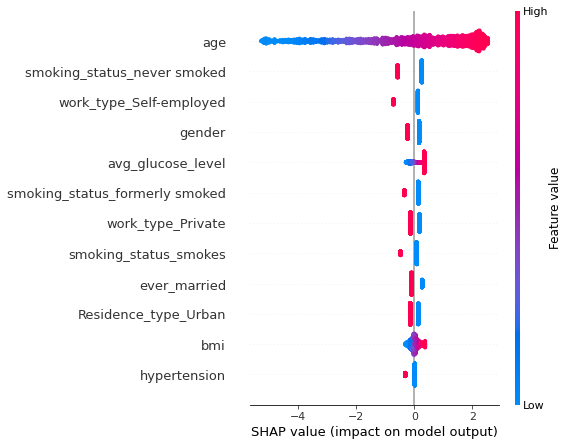

In [77]:
shap.summary_plot(logit_shap_values, X_test_res)

From this shap summary plot,we can not only observe the feature importance but also their effect direction on shap values.<br/>
In general, 'age' is most important among these features and lower value lead more probability to not having heart attack. 
Followed with 'smoke_status_never_smoke' and 'worktype_self_employee', the 'smoke_status_never_smoke' is true then lower probability patient have heart attack.
And observe the distribution of 'age', instance of lower age extend further towards the left, suggesting low age has stronger negative impact to make a having  stroke prediction than the positive impact of higher age. <br/>
Check the bottom instance distribution of 'hypertension' and 'bmi' , these features has almost no influence upon shap output.

### Conclusion
In this notebook, after feature selection, logistic regression model perform slightly better than without feature selection, also become more interpretable. And the age is most important feature for the prediction which is way more significant than others. and the test accuracy of model is about 86%.
### Reference
[1]https://www.kaggle.com/code/gaetanlopez/how-to-make-clean-visualizations/data <br/>
[2]https://www.kaggle.com/code/dansbecker/shap-values <br/>
[3]https://shap.readthedocs.io/en/latest/ <br/>
[4]https://github.com/ajhalthor/model-interpretability/blob/main/Shap%20Values.ipynb<br/>
codes refer to [2] and [3], modified parameters for experiments.

### Liciense
Copyright 2022 Yanping Fu

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.